### SAMSUNG

### Load Data

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

#csv 파일 읽기
dataset_filepath =  os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
#time series 추출
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-02-25    57900.0
2020-02-26    56500.0
2020-02-27    55900.0
2020-02-28    54200.0
2020-03-02    55000.0
Name: Close, dtype: float64

### Preprocessing

In [90]:
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

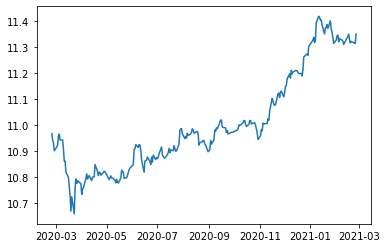

In [91]:
#log 함수 변환 (시간 추이에 따라 분산이 점점 커지고 있을 때)
ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

### EDA

In [92]:
# 일정 시간내 구간 통계치(Rolling Statistics)를 시각화 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  
    rolstd = timeseries.rolling(window=window).std()
    
    # 원본 시계열, 이동평균, 이동표준편차를 plot으로 시각회해본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [93]:
# adfuller활용한 augmented_dickey_fuller_test 함수
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출한다.
    dftest = adfuller(timeseries, autolag='AIC')  
   
    # adfuller 메소드가 리턴한 결과를 정리하여 출력한다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

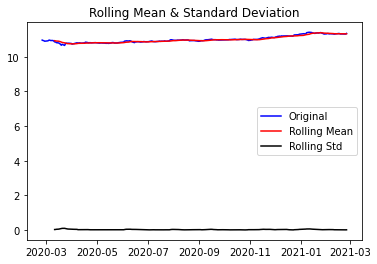

Results of Dickey-Fuller Test:
Test Statistic                   0.080457
p-value                          0.964701
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


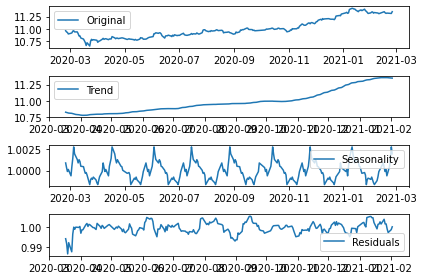

In [94]:
# 시계열 데이터 안정성 확인
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해(TIme Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

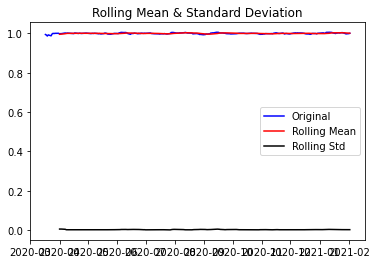

Results of Dickey-Fuller Test:
Test Statistic                  -5.120475
p-value                          0.000013
#Lags Used                       0.000000
Number of Observations Used    218.000000
Critical Value (1%)             -3.460708
Critical Value (5%)             -2.874891
Critical Value (10%)            -2.573886
dtype: float64


In [95]:
# Residual 안정성 확인
plot_rolling_statistics(residual)

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

### Dataset

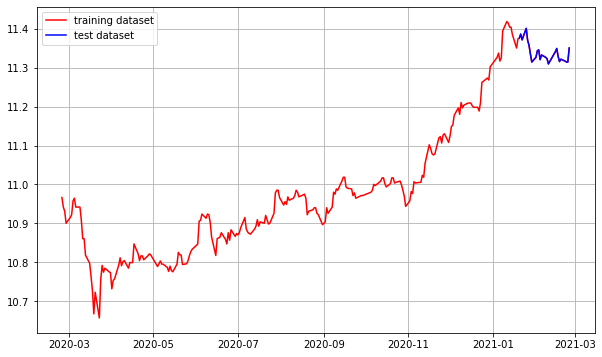

In [96]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### ARIMA

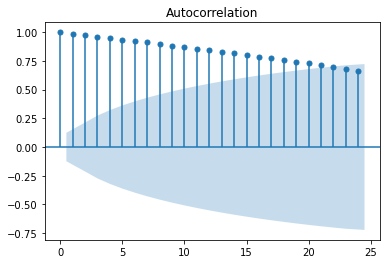

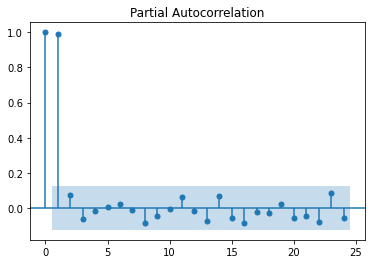

In [97]:
# ACF, PACF 그려보기 -> p, q 구하기
plot_acf(ts_log)   
plot_pacf(ts_log)  
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.595823e+01
p-value                        7.227588e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


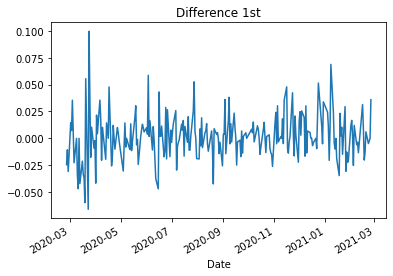

In [98]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.509433e+00
p-value                        4.052327e-11
#Lags Used                     1.300000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


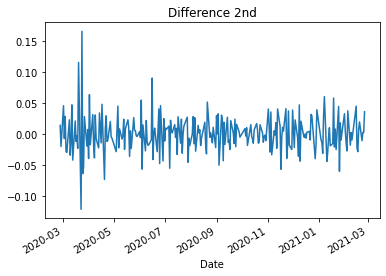

In [99]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)


### Train & Test

In [100]:
#Build and Train Model
# p, d, q = 1, 1, 0
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 538.814
Method:                       css-mle   S.D. of innovations              0.022
Date:                Thu, 25 Feb 2021   AIC                          -1071.628
Time:                        14:24:16   BIC                          -1061.407
Sample:                             1   HQIC                         -1067.502
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0018      0.001      1.284      0.199      -0.001       0.005
ar.L1.D.Close    -0.0170      0.067     -0.253      0.800      -0.149       0.115
                                    Root

/home/aiffel-dj51/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj51/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

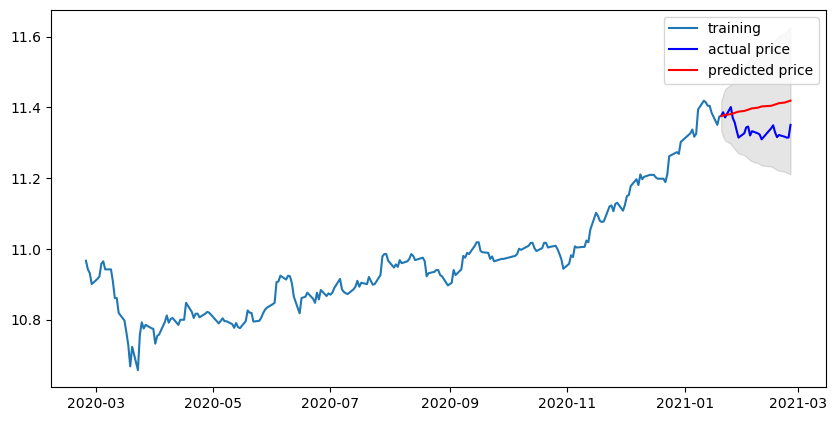

In [101]:
# 테스트 및 플로팅
# Forecast : 결과가 fc에 담깁니다.
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05) #95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index) #예측결과 
lower_series = pd.Series(conf[:, 0], index=test_data.index) #예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index) #예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [102]:
# 최종 예측 모델 정확도 측정(MAPE)
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  33573467.64786159
MAE:  5160.393407051683
RMSE:  5794.261613688287
MAPE: 6.21%


### Alphabet Inc. (GOOG)

### Load Data

In [57]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/GOOG.csv'

# Time Series 생성
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
google_ts = df['Close']
print(type(ts))
google_ts.head()

<class 'pandas.core.series.Series'>


Date
2004-08-19    49.982655
2004-08-20    53.952770
2004-08-23    54.495735
2004-08-24    52.239197
2004-08-25    52.802086
Name: Close, dtype: float64

### Preprocessing

In [58]:
google_ts=google_ts.interpolate(method='time')
google_ts[google_ts.isna()]

Series([], Name: Close, dtype: float64)

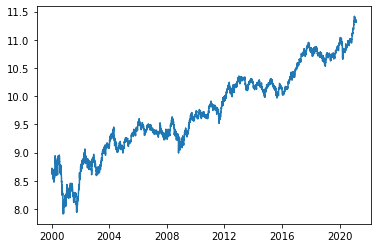

In [59]:
google_ts_log = np.log(google_ts)
plt.plot(ts_log)
plt.show()

### EDA

In [60]:
# 일정 시간내 구간 통계치(Rolling Statistics)를 시각화 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  
    rolstd = timeseries.rolling(window=window).std()

    # 원본 시계열, 이동평균, 이동표준편차를 plot으로 시각회해본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [61]:
# adfuller활용한 augmented_dickey_fuller_test 함수
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출한다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력한다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

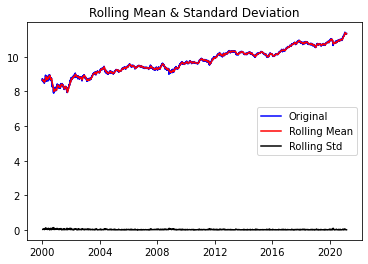

Results of Dickey-Fuller Test:
Test Statistic                   -1.835655
p-value                           0.362909
#Lags Used                        7.000000
Number of Observations Used    4150.000000
Critical Value (1%)              -3.431927
Critical Value (5%)              -2.862237
Critical Value (10%)             -2.567141
dtype: float64


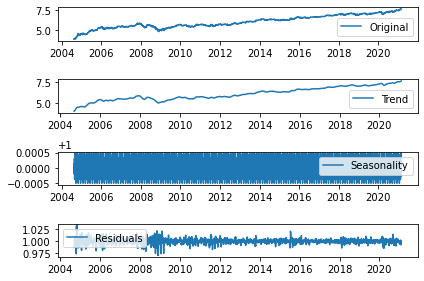

In [62]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(google_ts_log)

# 시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(google_ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(google_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

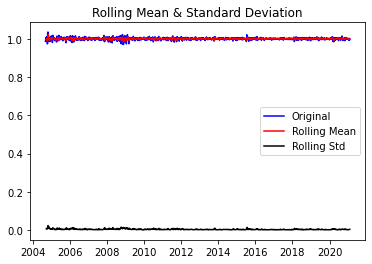

Results of Dickey-Fuller Test:
Test Statistic                -1.483506e+01
p-value                        1.873836e-27
#Lags Used                     3.000000e+01
Number of Observations Used    4.097000e+03
Critical Value (1%)           -3.431947e+00
Critical Value (5%)           -2.862246e+00
Critical Value (10%)          -2.567146e+00
dtype: float64


In [63]:
# Residual 안정성 확인
plot_rolling_statistics(residual)

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

### Dataset

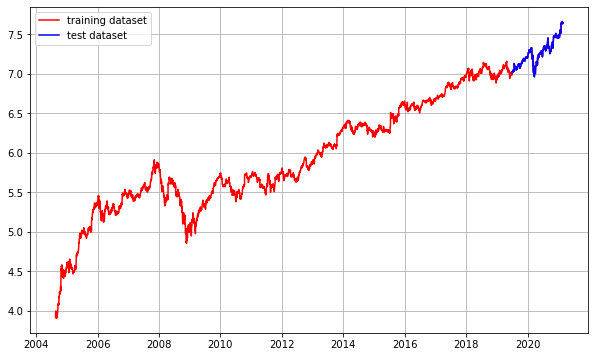

In [64]:
train_data, test_data = google_ts_log[:int(len(google_ts_log)*0.9)], google_ts_log[int(len(google_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(google_ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### ARIMA

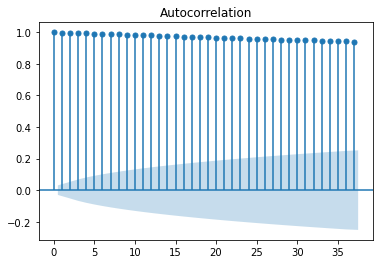

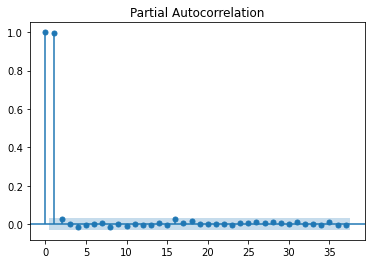

In [65]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(google_ts_log)   
plot_pacf(google_ts_log)  
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -24.611490
p-value                           0.000000
#Lags Used                        6.000000
Number of Observations Used    4150.000000
Critical Value (1%)              -3.431927
Critical Value (5%)              -2.862237
Critical Value (10%)             -2.567141
dtype: float64


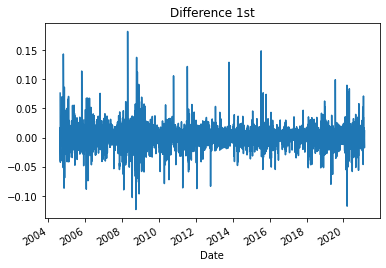

In [66]:
# 차분 안정성 확인 -> d 구하기
diff_1 = google_ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                  -20.571352
p-value                           0.000000
#Lags Used                       31.000000
Number of Observations Used    4124.000000
Critical Value (1%)              -3.431937
Critical Value (5%)              -2.862241
Critical Value (10%)             -2.567143
dtype: float64


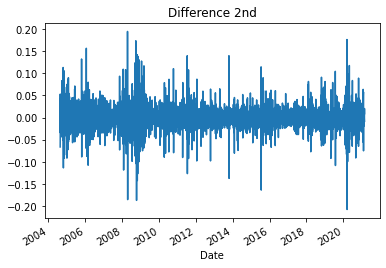

In [67]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### Train & Test

In [68]:
# Build and Train  Model
# p, d, q
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  

print('-'*90)

print(fitted_m.summary())

------------------------------------------------------------------------------------------
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3741
Model:                 ARIMA(1, 1, 0)   Log Likelihood                9539.796
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 25 Feb 2021   AIC                         -19073.592
Time:                        13:48:37   BIC                         -19054.911
Sample:                             1   HQIC                        -19066.948
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      2.646      0.008       0.000       0.001
ar.L1.D.Close     0.0106      0

/home/aiffel-dj51/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj51/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

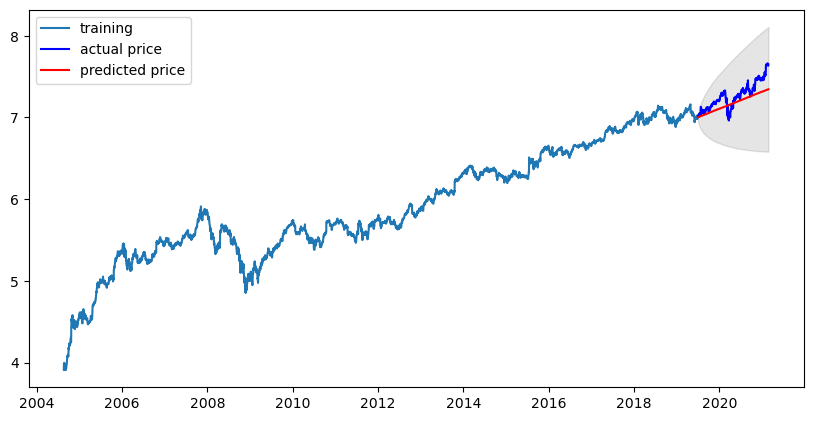

In [69]:
# Forecast : 결과가 fc에 담깁니다.
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index) 
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [70]:
# 최종 예측 모델 정확도 측정(MAPE)
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  37258.193657899545
MAE:  152.79716985254328
RMSE:  193.0238162971076
MAPE: 9.84%


### Amazon.com, Inc. (AMZN)

### Load Data

In [130]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AMZN.csv'

# Time Series 생성
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts_amz = df['Close']
print(type(ts_amz))
ts_amz.head()

<class 'pandas.core.series.Series'>


Date
2019-03-25    1774.260010
2019-03-26    1783.760010
2019-03-27    1765.699951
2019-03-28    1773.420044
2019-03-29    1780.750000
Name: Close, dtype: float64

### Preprocessing

In [131]:
ts_amz=ts_amz.interpolate(method='time')
ts_amz[ts_amz.isna()]

Series([], Name: Close, dtype: float64)

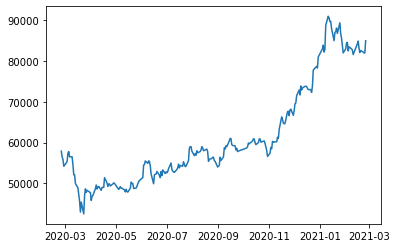

In [132]:
#log 함수 변환 (시간 추이에 따라 분산이 점점 커지고 있을 때)
ts_amz_log = np.log(ts_amz)
plt.plot(ts)
plt.show()

### EDA

In [133]:
# 일정 시간내 구간 통계치(Rolling Statistics)를 시각화 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  
    rolstd = timeseries.rolling(window=window).std()
    
    # 원본 시계열, 이동평균, 이동표준편차를 plot으로 시각회해본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [134]:
# adfuller활용한 augmented_dickey_fuller_test 함수
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출한다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력한다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

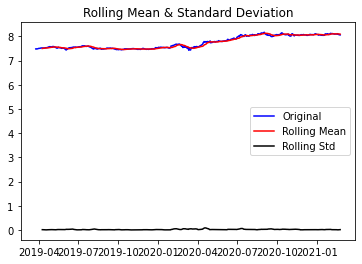

Results of Dickey-Fuller Test:
Test Statistic                  -0.638964
p-value                          0.861932
#Lags Used                       9.000000
Number of Observations Used    475.000000
Critical Value (1%)             -3.444192
Critical Value (5%)             -2.867644
Critical Value (10%)            -2.570021
dtype: float64


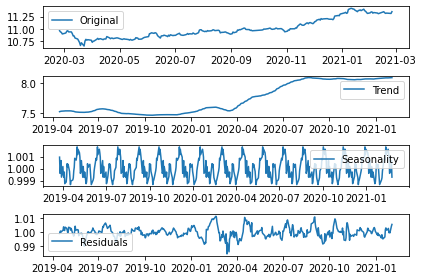

In [135]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_amz_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_amz_log)

# 시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_amz_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

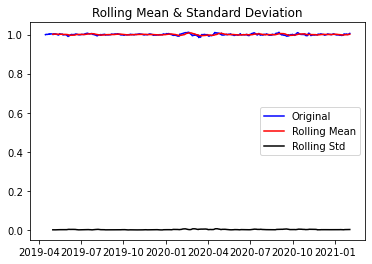

Results of Dickey-Fuller Test:
Test Statistic                -7.282226e+00
p-value                        1.490073e-10
#Lags Used                     1.200000e+01
Number of Observations Used    4.420000e+02
Critical Value (1%)           -3.445232e+00
Critical Value (5%)           -2.868101e+00
Critical Value (10%)          -2.570265e+00
dtype: float64


In [136]:
# Residual 안정성 확인
plot_rolling_statistics(residual)

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

### DataSet

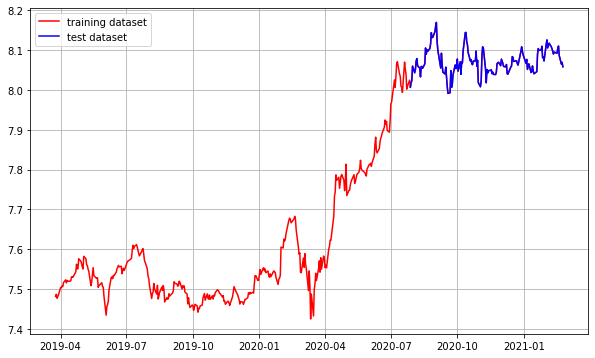

In [137]:
train_data, test_data = ts_amz_log[:int(len(ts_amz_log)*0.7)], ts_amz_log[int(len(ts_amz_log)*0.7):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_amz_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### ARIMA

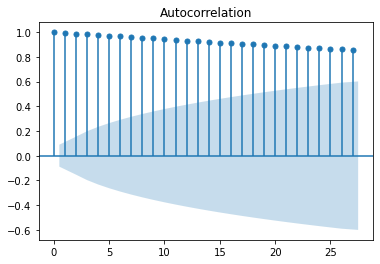

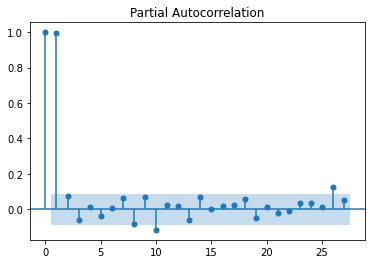

In [138]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf(ts_amz_log)   
plot_pacf(ts_amz_log)  
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -6.598858e+00
p-value                        6.815788e-09
#Lags Used                     8.000000e+00
Number of Observations Used    4.750000e+02
Critical Value (1%)           -3.444192e+00
Critical Value (5%)           -2.867644e+00
Critical Value (10%)          -2.570021e+00
dtype: float64


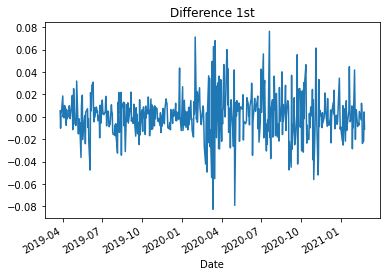

In [139]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_amz_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.150501e+01
p-value                        4.397519e-21
#Lags Used                     1.000000e+01
Number of Observations Used    4.720000e+02
Critical Value (1%)           -3.444281e+00
Critical Value (5%)           -2.867683e+00
Critical Value (10%)          -2.570042e+00
dtype: float64


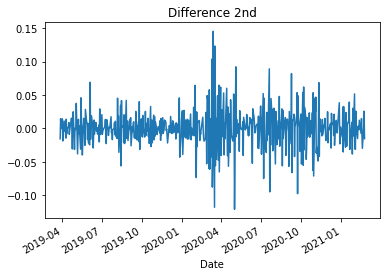

In [140]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### Train & Test

In [141]:
# Build and Train  Model
# p, d, q
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  

print('-'*90)

print(fitted_m.summary())

------------------------------------------------------------------------------------------
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  338
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 856.669
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 25 Feb 2021   AIC                          -1707.339
Time:                        14:34:43   BIC                          -1695.870
Sample:                             1   HQIC                         -1702.768
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0016      0.001      1.746      0.081      -0.000       0.003
ar.L1.D.Close    -0.1385      0

/home/aiffel-dj51/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj51/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

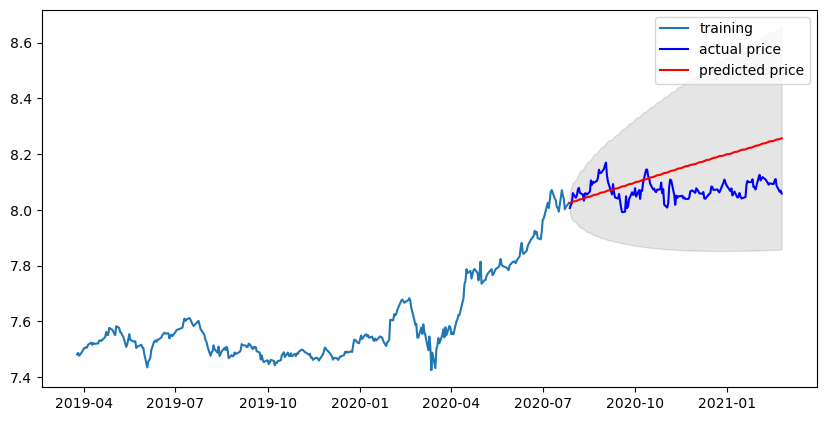

In [142]:
# Forecast : 결과가 fc에 담깁니다.
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05) # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index) # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index) # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index) # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [143]:
# 최종 예측 모델 정확도 측정(MAPE)
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  113756.85243341113
MAE:  289.8342752231487
RMSE:  337.27859765097924
MAPE: 9.05%


### 느낀점(회고)

In [ ]:
삼성, Alphabet(구글), 아마존의 주식가격을 예측해보았습니다.


각각 MAPE의 결과는 다음과 같습니다.

삼성 : 6.21%
Alphabet(구글) : 9.84%
아마존 : 9.05%
